# Loading preprocessed data

In [172]:
import numpy as np
# import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Input, MaxPooling2D, Add, GlobalAveragePooling2D, Reshape, Bidirectional, Dense, Flatten, Dropout, SpatialDropout2D
from tensorflow.keras.models import Model
from keras.layers import CuDNNLSTM, RepeatVector
from time import time
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix   
import wave
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,7)

In [197]:
class ResNetLstm():
    """
    Usage: 
        sr = ResNetLstm([4,8,16], input_size=(50,50,1), output_size=12)
        sr.build()
        followed by sr.m.compile(loss='categorical_crossentropy', 
                                 optimizer='adadelta', metrics=["accuracy"])
        save plotted model with: 
            keras.utils.plot_model(sr.m, to_file = '<location>.png', 
                                   show_shapes=True)
    """
    def __init__(self,
                 filters_list=[], 
                 input_size=None, 
                 output_size=None,
                 initializer='glorot_uniform'):
        self.filters_list = filters_list
        self.input_size = input_size
        self.output_size = output_size
        self.initializer = initializer
        self.m = None        
    
    def _block(self, filters, inp):
        """ one residual block in a ResNetLstm
        
        Args:
            filters (int): number of convolutional filters
            inp (tf.tensor): output from previous layer
            
        Returns:
            tf.tensor: output of residual block
        """
        layer_1 = BatchNormalization()(inp)
        act_1 = Activation('relu')(layer_1)
        conv_1 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_1)
        layer_2 = BatchNormalization()(conv_1)
        act_2 = Activation('relu')(layer_2)
        conv_2 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_2)
        return(conv_2)
    def build(self):
        """
        Returns:
            keras.engine.training.Model
        """

        print('1shapes: ', self.input_size)
        i = Input(shape = self.input_size, name = 'input')
        x = Conv2D(self.filters_list[0], (3,3), 
                   padding = 'same',
                   kernel_initializer = self.initializer)(i)
        print('2shapes: ', x.shape)
        x = MaxPooling2D((1,3))(x)
        # x = MaxPooling2D(padding = 'same')(x)
        print('3shapes: ', x.shape)
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        if len(self.filters_list) > 1:
            for filt in self.filters_list[1:]:
                print(filt)
                x = Conv2D(filt, (3,3),
                           strides = (1,1),
                           padding = 'same',
                           activation = 'relu',
                           kernel_initializer = self.initializer)(x)
                x = MaxPooling2D((1,3))(x)
                print('6shapes: ', x.shape)
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
        # x = GlobalAveragePooling2D()(x)
        
        x = Reshape((85,4*32))(x)
        print('7shapes: ', x.shape)
        x = Bidirectional(CuDNNLSTM(64,return_sequences=True))(x)
        print('8shapes: ', x.shape)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Bidirectional(CuDNNLSTM(32,return_sequences=True))(x)
        print('9shapes: ', x.shape)
        x = Reshape((85,2*32))(x)
        print('0shapes: ', x.shape)
        print('output_size: ', self.output_size)
        x = Flatten()(x)
        print('1shapes: ', x.shape)
        x = Dropout(0.2)(x)
        
        x = Dense(self.output_size, activation = 'softmax')(x)
        print('2shapes: ', x.shape)
        
        self.m = Model(i,x)
        return self.m

In [13]:
# temporarely unused
def load_wave(filename):
   # Read file to get buffer                                                                                               
   ifile = wave.open(filename)
   samples = ifile.getnframes()
   audio = ifile.readframes(samples)

   # Convert buffer to float32 using NumPy                                                                                 
   audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
   audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

   # Normalise float32 array so that values are between -1.0 and +1.0                                                      
   max_int16 = 2**15
   audio_normalised = audio_as_np_float32 / max_int16
   return audio_normalised

### import training and validation data (not included in repo)

In [177]:
path = '/home2/faculty/kmrozowski/rl2/wut-mini-deep-learning/speech-recognition/'
X_train = np.load(path+'data/X_train.npy').transpose((0,2,1,3))
Y_train = np.load(path+'data/Y_train.npy')
X_val = np.load(path+'data/X_val.npy').transpose((0,2,1,3))
Y_val = np.load(path+'data/Y_val.npy')

In [178]:
X_train.shape
# (58284, 122, 85, 1) -> (n_samples, frequencies, timestamps, 1)

(58284, 85, 122, 1)

In [179]:
path = '/dev/shm/kmrozowski/'
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']
all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir(path + 'data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'zero', 'wow', 'two', 'tree', 'three', 'six', 'sheila', 'seven', 'one', 'nine', 'marvin', 'house', 'happy', 'four', 'five', 'eight', 'dog', 'cat', 'bird', 'bed']


In [180]:
# for label in all_classes:
#    print(data[label].shape, ':)')

### The training data is very unbalanced with a much larger 'unknown' class. Keras has a class_weight paramter in the fit() function that will give higher penalties to missclassifications in underrepresented classes. It takes a dict like this:

In [181]:
def get_class_weights(y):
   counter = Counter(y)
   majority = max(counter.values())
   return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights = get_class_weights(Y_train)


In [182]:
class_weights

{11: 1.0,
 0: 17.399810964083176,
 3: 17.574224343675418,
 10: 101.98891966759003,
 1: 17.490736342042755,
 5: 17.441023211747986,
 9: 17.432765151515152,
 2: 17.4080378250591,
 6: 17.449289099526066,
 8: 17.253045923149017,
 4: 17.482431149097817,
 7: 17.52403617325083}

some constants we need for all models

In [183]:
input_size = X_train.shape[1:]
batch_size = 196

## The ResNet
### declare filters for each block of blocks and set output size.

In [184]:
filters_list = [8,16,32]
output_size = 12

In [185]:
#adjust these strings for organizeing the saved files
date = '20220430'
arch = 'resnetlstm8_16_32_128'

### Build the model

In [198]:
sr = ResNetLstm(filters_list, input_size, output_size)
sr.build()
sr.m.compile(loss='categorical_crossentropy', 
             optimizer='adadelta', 
             metrics=['accuracy'])
# 1shapes:  (85, 122, 1)
# 2shapes:  (None, 85, 122, 1)
# 3shapes:  (None, 85, 122, 8)
# 4shapes:  (None, 43, 61, 8)
# 1shapes:  (None, 22, 31, 16)
# 1shapes:  (None, 11, 16, 32)
# 5shapes:  (None, 32)
# 6shapes:  (None, 12)

# 1shapes:  (85, 122, 1)
# 2shapes:  (None, 85, 122, 8)
# 3shapes:  (None, 85, 40, 8)
# 6shapes:  (None, 85, 40, 16)
# 6shapes:  (None, 85, 40, 32)
# 7shapes:  (None, 85, 1280)
# 8shapes:  (None, 85, 256)
# 9shapes:  (None, 85, 128)
# 0shapes:  (None, 85, 128)
# 1shapes:  (None, 10880)
# 2shapes:  (None, 12)

1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  12
1shapes:  (None, 5440)
2shapes:  (None, 12)


In [199]:
sr.m.summary()
# Total params: 80,540
# Trainable params: 79,868
# Non-trainable params: 672

# Total params: 286,748
# Trainable params: 285,820
# Non-trainable params: 928

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 85, 122, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_1289 (Conv2D)           (None, 85, 122, 8)   80          ['input[0][0]']                  
                                                                                                  
 max_pooling2d_85 (MaxPooling2D  (None, 85, 40, 8)   0           ['conv2d_1289[0][0]']            
 )                                                                                                
                                                                                           

In [200]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr.m,
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [201]:
#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)

### Train the model. The history object stores training data for later access, like plotting training curves

In [202]:
history = sr.m.fit(X_train, 
                   to_categorical(Y_train), 
                   batch_size = batch_size, 
                   epochs = 2000,
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights,
                   validation_data = (X_val, to_categorical(Y_val)), 
                   callbacks = [checkpointer, tensorboard]) # add more callbacks if you want

Epoch 1/2000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date)) 

### Plot the training graphs, and save them

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


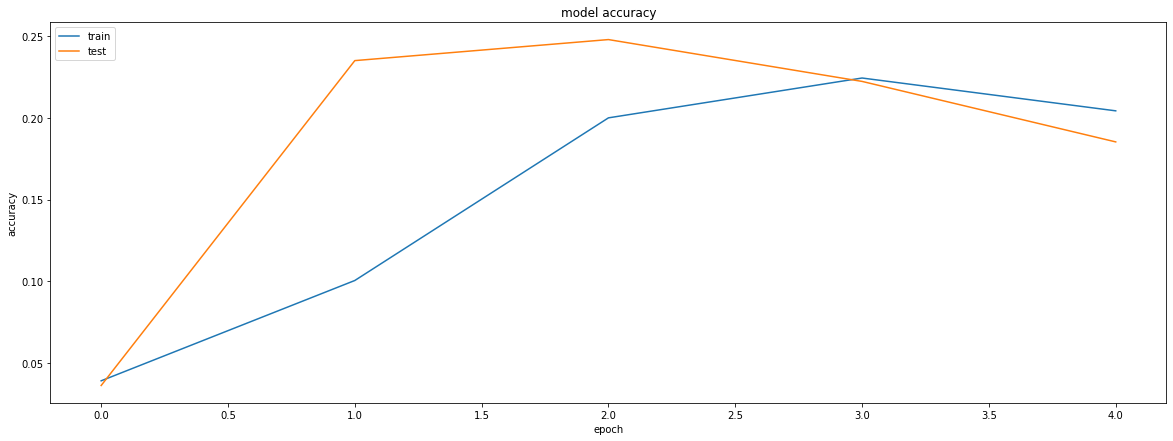

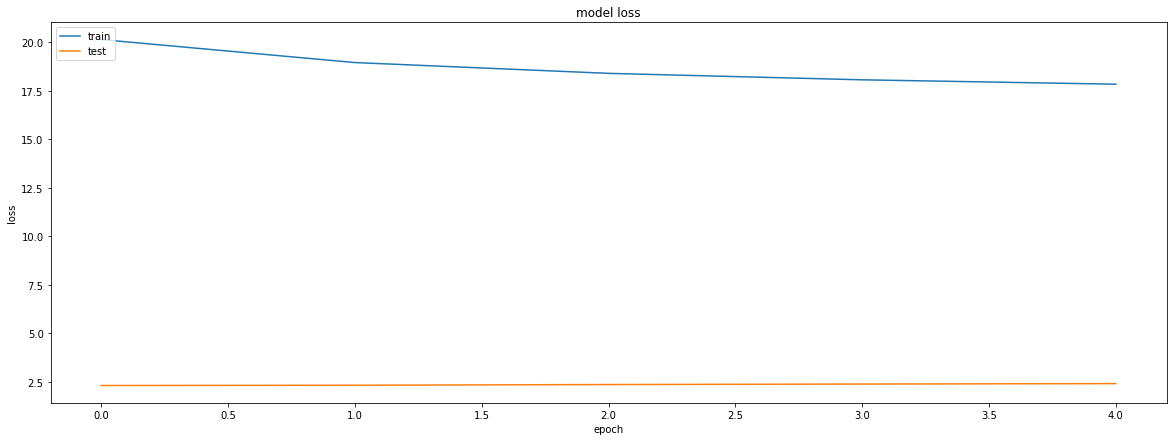

In [ ]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

### Predict the validation classification and score

In [ ]:
val_pred = sr.m.predict(X_val, batch_size = batch_size, verbose = 1)

35/35 [==============================] - 1s 17ms/step


In [15]:
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))

              precision    recall  f1-score   support

         yes      0.000     0.000     0.000       261
          no      0.000     0.000     0.000       270
          up      0.000     0.000     0.000       260
        down      0.041     0.981     0.079       264
        left      0.000     0.000     0.000       247
       right      0.000     0.000     0.000       256
          on      0.000     0.000     0.000       257
         off      0.000     0.000     0.000       256
        stop      0.000     0.000     0.000       246
          go      0.031     0.069     0.043       260
     silence      0.000     0.000     0.000        41
     unknown      0.000     0.000     0.000      4221

    accuracy                          0.041      6839
   macro avg      0.006     0.088     0.010      6839
weighted avg      0.003     0.041     0.005      6839



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
print(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1)))

[[   0    0    0  199    0    0    0    0    0   62    0    0]
 [   0    0    0  262    0    0    0    0    0    8    0    0]
 [   0    0    0  227    0    0    0    0    0   33    0    0]
 [   0    0    0  259    0    0    0    0    0    5    0    0]
 [   0    0    0  228    0    0    0    0    0   19    0    0]
 [   0    0    0  246    0    0    0    0    0   10    0    0]
 [   0    0    0  244    0    0    0    0    0   13    0    0]
 [   0    0    0  239    0    0    0    0    0   17    0    0]
 [   0    0    0  204    0    0    0    0    0   42    0    0]
 [   0    0    0  242    0    0    0    0    0   18    0    0]
 [   0    0    0   41    0    0    0    0    0    0    0    0]
 [   0    0    0 3865    0    0    0    0    0  356    0    0]]


In [17]:
plt.figure(figsize = (8,8))
plt.imshow(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1), labels = classes))
plt.xticks(np.arange(0, len(classes)), classes, rotation = 'vertical', size = 12)
plt.yticks(np.arange(0, len(classes)), classes, size = 12)
plt.show()

ValueError: At least one label specified must be in y_true

<Figure size 576x576 with 0 Axes>